In [1]:
# !pip install yahoofinancials
# import yahoofinancials

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from datetime import date
from datetime import timedelta
from yahoofinancials import YahooFinancials
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
import warnings
warnings.filterwarnings('ignore')

In [3]:
end = '2021-08-12'
start = '2016-07-20'

stock_symbol = 'TCS.NS'
yf = YahooFinancials(stock_symbol)
data = yf.get_historical_price_data(start, end, 'daily')
TCS = pd.DataFrame(data['TCS.NS']['prices'])
TCS = TCS.drop('date', axis=1).set_index('formatted_date')
TCS['Date'] = pd.to_datetime(TCS.index, format="%Y-%m-%d")
TCS.set_index('Date', drop=False, inplace=True)


In [4]:
df = TCS.dropna()

In [5]:
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']
df.head()

,high,low,open,close,volume,adjclose,Date
Date,,,,,,,
2016-07-20,1251.250000,1224.074951,1225.000000,1247.474976,2815252.0,1129.042114,2016-07-20
2016-07-21,1259.750000,1232.224976,1244.750000,1253.025024,2527148.0,1134.065430,2016-07-21
2016-07-22,1262.000000,1246.000000,1249.449951,1257.550049,1517216.0,1138.160645,2016-07-22
2016-07-25,1281.599976,1252.900024,1256.000000,1279.474976,1688796.0,1161.004517,2016-07-25
2016-07-26,1284.000000,1266.500000,1279.474976,1276.300049,2311290.0,1158.123901,2016-07-26


In [6]:
data = df.sort_index(ascending=True, axis=0)

In [7]:
FullData = data[['close']].values

In [8]:
sc = MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X = DataScaler.transform(FullData)

In [9]:
X = X.reshape(X.shape[0],) 

In [10]:
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps = 30   # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps = 30 # How many days in future you want to predict the prices
 
# Iterate through the values to create combinations
for i in range(TimeSteps, NumerOfRows-FutureTimeSteps):
    
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data = np.array(X_samples)
X_data = X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)

In [11]:
trl = int(0.95 * len(X_data))

In [12]:
# Splitting the data into train and test
X_train = X_data[:trl]
X_test = X_data[trl:]

y_train = y_data[:trl]
y_test = y_data[trl:]

In [13]:
y_data.shape

(1188, 30)

In [14]:
TimeSteps = X_train.shape[1]
TotalFeatures = X_train.shape[2]

In [15]:
model = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
model.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 

# Adding the Second hidden layer and the LSTM layer
model.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Third hidden layer and the LSTM layer
model.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
model.add(Dense(units = FutureTimeSteps))

In [16]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 5)             320       
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense (Dense)                (None, 30)                180       
Total params: 1,200
Trainable params: 1,200
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train, y_train, batch_size = 128, epochs = 100)

Epoch 1/100
9/9 [==============================] - 5s 53ms/step - loss: 0.1844
Epoch 2/100
9/9 [==============================] - 0s 39ms/step - loss: 0.1781
Epoch 3/100
9/9 [==============================] - 0s 47ms/step - loss: 0.1720
Epoch 4/100
9/9 [==============================] - 1s 65ms/step - loss: 0.1661
Epoch 5/100
9/9 [==============================] - 1s 71ms/step - loss: 0.1604
Epoch 6/100
9/9 [==============================] - 1s 61ms/step - loss: 0.1550
Epoch 7/100
9/9 [==============================] - 1s 60ms/step - loss: 0.1497
Epoch 8/100
9/9 [==============================] - 0s 33ms/step - loss: 0.1446
Epoch 9/100
9/9 [==============================] - 0s 52ms/step - loss: 0.1398
Epoch 10/100
9/9 [==============================] - 1s 59ms/step - loss: 0.1352
Epoch 11/100
9/9 [==============================] - 1s 60ms/step - loss: 0.1308
Epoch 12/100
9/9 [==============================] - 0s 37ms/step - loss: 0.1265
Epoch 13/100
9/9 [==============================]

In [19]:
X_test.shape

(60, 30, 1)

In [20]:
predicted_Price = model.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig = y_test
orig = DataScaler.inverse_transform(y_test) 

In [21]:
from sklearn.metrics import mean_squared_error

mean_squared_error(orig, predicted_Price)

1726554.9991177714

Next 30 days prediction

In [22]:
Last60DaysPrices = FullData[-TimeSteps:]
 
# Reshaping the data to (-1,1 )because its a single entry
Last60DaysPrices=Last60DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last60DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next30DaysPrice = model.predict(X_test)

# Generating the prices in original scale
Next30DaysPrice = DataScaler.inverse_transform(Next30DaysPrice)
Next30DaysPrice

 


array([[1861.0259, 1862.6449, 1864.3087, 1866.0162, 1867.7429, 1869.5625,
        1871.3844, 1873.1278, 1874.785 , 1876.519 , 1878.2224, 1879.8645,
        1881.4598, 1883.0723, 1884.6764, 1886.2512, 1887.891 , 1889.4895,
        1891.0698, 1892.5736, 1894.0815, 1895.6183, 1897.193 , 1898.7874,
        1900.392 , 1902.0142, 1903.606 , 1905.191 , 1906.7617, 1908.3466]],
      dtype=float32)

In [23]:
Next30DaysPrice = Next30DaysPrice.reshape((-1, 1))
Next30DaysPrice

array([[1861.0259],
       [1862.6449],
       [1864.3087],
       [1866.0162],
       [1867.7429],
       [1869.5625],
       [1871.3844],
       [1873.1278],
       [1874.785 ],
       [1876.519 ],
       [1878.2224],
       [1879.8645],
       [1881.4598],
       [1883.0723],
       [1884.6764],
       [1886.2512],
       [1887.891 ],
       [1889.4895],
       [1891.0698],
       [1892.5736],
       [1894.0815],
       [1895.6183],
       [1897.193 ],
       [1898.7874],
       [1900.392 ],
       [1902.0142],
       [1903.606 ],
       [1905.191 ],
       [1906.7617],
       [1908.3466]], dtype=float32)

In [24]:
def predict_dates(num_prediction):
    last_date = end
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

In [25]:
forecast_dates = predict_dates(FutureTimeSteps-1)

In [26]:
fd = pd.DataFrame(Next30DaysPrice, index=forecast_dates)

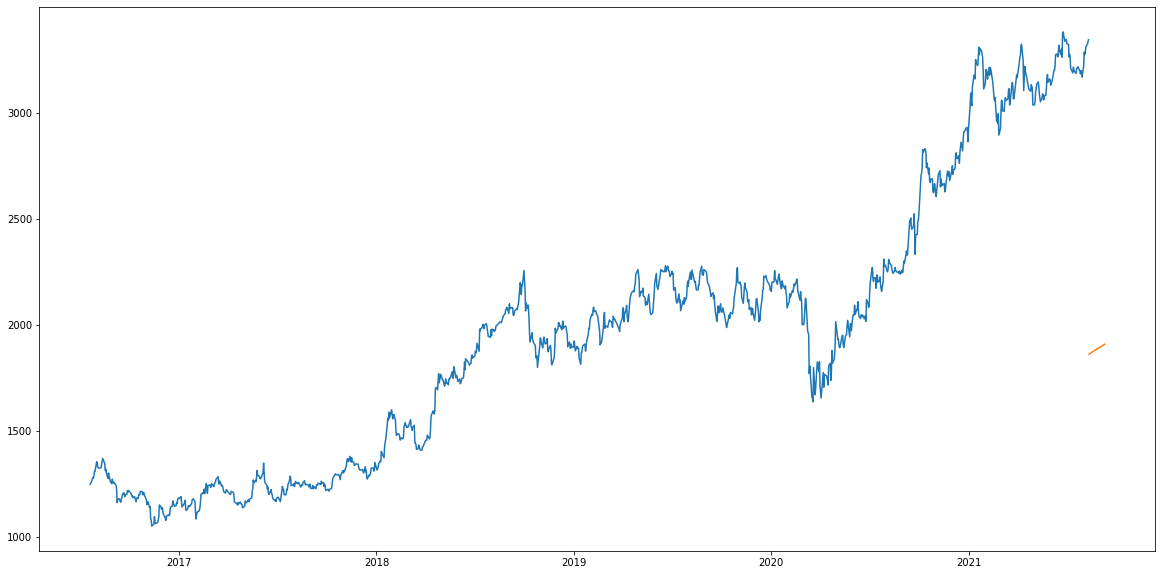

In [27]:
plt.plot(df['close'])
plt.plot(fd)

Keras Tuning

In [28]:
# !pip install -U keras-tuner

In [29]:
from keras_tuner.tuners import randomsearch
from keras_tuner.tuners import BayesianOptimization
from tensorflow import keras
import tensorflow as tf

In [30]:
def build(hp):


    activation = hp.Choice('activation', 
                        [
                          'relu',
                          'tanh'
                         
                          ])

    lstm_layers = hp.Int(
                        'num_lstm_layers', 
                        min_value=0,
                        max_value=60,
                        default=3)

    # recurrent_dropout = hp.Float(
    #                     'recurrent_dropout', 
    #                     min_value=0.0,
    #                     max_value=0.99,
    #                     default=0.2)
    num_units = hp.Int(
                        'num_units', 
                        min_value=0,
                        max_value=300,
                        default=32)
    
    model = Sequential()
    model.add(LSTM(units=num_units, activation=activation, #recurrent_dropout = recurrent_dropout,
                   return_sequences=True,input_shape=(TimeSteps, TotalFeatures)))

    model.add(Dense(1))
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-1,])))


#    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate',min_value=1e-10,max_value=1e-2,sampling='LOG',default=1e-6),loss=tf.losses.MeanSquaredError(),metrics=['mse'])
    return model

In [31]:
import os
bayesian_opt_tuner = BayesianOptimization(
    build,
 objective ='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/kera'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)
n_epochs=100


In [32]:
print(X_train.shape,y_train.shape )

(1128, 30, 1) (1128, 30)


In [33]:
bayesian_opt_tuner.search(X_train, y_train,epochs=n_epochs, 
                          validation_data=(X_test, y_test),
                          validation_split=0.2,verbose=1)


Trial 3 Complete [00h 06m 52s]
mse: 0.002270167227834463

Best mse So Far: 0.002270167227834463
Total elapsed time: 00h 12m 22s
INFO:tensorflow:Oracle triggered exit


In [41]:
bestHP = bayesian_opt_tuner.get_best_hyperparameters(num_trials=3)[0].values

In [42]:
bestHP

{'activation': 'relu',
 'num_lstm_layers': 0,
 'num_units': 300,
 'learning_rate': 0.01}

Using best hyperparameters for the final model building

In [36]:
## time stamp =3
model=Sequential()
model.add(LSTM(38,activation='relu',return_sequences=True,input_shape=(3,1)))
model.add(LSTM(38,activation='relu',return_sequences=True))
model.add(LSTM(38,activation='relu',return_sequences=True))
model.add(LSTM(38,activation='relu',return_sequences=True))
model.add(LSTM(38,activation='relu',return_sequences=True))
model.add(LSTM(38,activation='relu',return_sequences=True))
model.add(LSTM(38,activation='relu',return_sequences=True))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error',optimizer='adam')

In [37]:
## time stamp =60
model=Sequential()
model.add(LSTM(46,activation='relu',return_sequences=True,input_shape=(60,1)))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error',optimizer=opt)

In [38]:
## time stamp =30
model=Sequential()
model.add(LSTM(46,activation='relu',return_sequences=True,input_shape=(30,1)))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error',optimizer=opt)

In [40]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=128,verbose=1)

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.0502

ValueError: Data cardinality is ambiguous:
  x sizes: 1
  y sizes: 60
Make sure all arrays contain the same number of samples.

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
X_train.shape

In [ ]:
train_predict= train_predict.reshape((1118,60))

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)

In [ ]:
train_predict

Next 30 days prediction

In [ ]:
TimeSteps =60


In [ ]:
Last60DaysPrices = FullData[-60:]
type(Last60DaysPrices)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
DataScaler = sc.fit(FullData)


In [ ]:
X_test

In [ ]:
Last60DaysPrices = FullData[-TimeSteps:]
 
# Reshaping the data to (-1,1 )because its a single entry
Last60DaysPrices=Last60DaysPrices.reshape(-1, 1)

# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last60DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,30,NumberofFeatures)

# Generating the predictions for next 5 days
Next30DaysPrice = model.predict(X_test)
 
Next30DaysPrice = DataScaler.inverse_transform(Next30DaysPrice)


In [ ]:
TimeSteps

In [ ]:
Next30DaysPrice.shape

In [ ]:
def predict_dates(num_prediction):
    last_date = end
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

In [ ]:
forecast_dates = predict_dates(60-1)

In [ ]:
fd = pd.DataFrame(Next30DaysPrice, index=forecast_dates)
fd

In [ ]:
end = '2021-09-03'
start = '2021-08-04'

stock_symbol = 'TCS.NS'
yf = YahooFinancials(stock_symbol)
data = yf.get_historical_price_data(start, end, 'daily')
TCS = pd.DataFrame(data['TCS.NS']['prices'])
TCS = TCS.drop('date', axis=1).set_index('formatted_date')
TCS['Date'] = pd.to_datetime(TCS.index, format="%Y-%m-%d")
TCS.set_index('Date', drop=False, inplace=True)
TCS


In [ ]:
plt.plot(df['close'])
plt.plot(fd)